In [41]:
"""Ouverture du corpus lemmatisé au format json, et génération des plots et mesures pour évaluer la qualité du corpus

Parameters
-----------
None

Returns
----------
affichage des plots et mesures dans le terminal"""

'Ouverture du corpus lemmatisé au format json, et génération des plots et mesures pour évaluer la qualité du corpus\n\nParameters\n-----------\nNone\n\nReturns\n----------\naffichage des plots et mesures dans le terminal'

In [3]:
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Fonction d'importation du corpus lemmatisé depuis un fichier json local:

In [4]:
def load_json(input_file: str):
    """Open and read json file

    Parameters
    ----------
    input_file : str

    Returns
    ---------
    corpus as a dictionnary of dictionnaries"""

    with input_file.open("r", encoding="utf-8") as f:
        data = json.load(f)

    return data

# Appel de la fonction et impression de la première review du corpus et de ses métadonnées à titre d'exemples:

In [5]:
corpus = load_json(Path("../data/clean/corpus_c_l_v1.json"))
print(corpus["reviews"]["reviews"][0])

{'customer_id': '76561197990951542', 'helpful_vote': 3430, 'product_id': '1716740', 'product_title': 'Starfield', 'review_body': '77hrs in : " finish " starfield . \n\n now , it have a ng+ mode which be intriguing , so I be actually still play it ... but the story actively encourage you to finish it multiple time .. and restart over and over and over , which be ... curious . so I be onboard . \n\n I be still on the fence about the title as a whole . \n\n enjoy it ? yes , very much . \n\n but it be hard to compare to previous title ( such as Fallout4 ) because I end up play those in a heavily modde state , which skew my memory of the raw , unmodded game . \n\n Starfield be currently raw and unmodded . it be an RPG . it be a story . it be not about exploration , space flight , or space trucking . it be an adventure . it have a story and you be a participant . \n\n the Bethesda feel be here in spade , and that include a clunky interface with awful / useless filter and option ( gadamn Beth

# Histogramme pour afficher le nombre de reviews par classe
Techniquement, cette étape n'est pas nécessaire : j'ai imposé un équilibre lors du scrapping. 


Cependant ce plot serait utile si je n'avais pas pu scrapper des données annotées me permettant d'imposer cet équilibre.

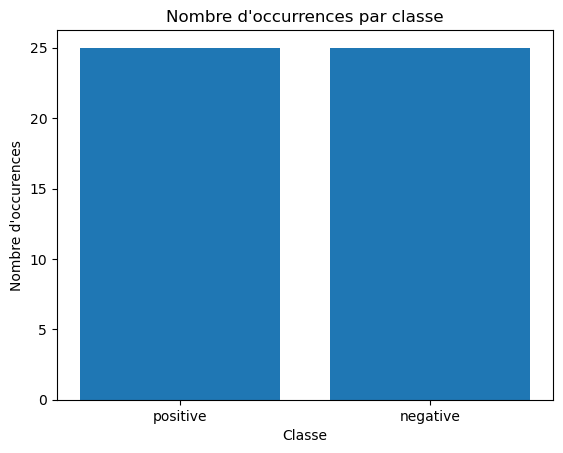

In [6]:
# récupérer les valeurs à partir du corpus
positif = 0
negatif = 0
for review in corpus["reviews"]["reviews"]:
    if review["score"] == 1:
        positif += 1
    else:
        negatif += 1

# plots :
valeurs = [positif, negatif]
categories = ["positive", "negative"]

plt.bar(categories, valeurs)

# Titres + étiquettes
plt.title("Nombre d'occurrences par classe")
plt.xlabel("Classe")
plt.ylabel("Nombre d'occurences")

plt.show()

# Avec une mesure :
Il est également possible de faire cette vérifcation de façon purement mathématique avec la valeur suivante qui représente le nombre de texte de la catégorie la plus petite divisé par le nombre de textes de la catégorie la plus grande. Le but pour un corpus est d'avoir le résultat le plus proche de 1 possible (ce qui est le cas ici, puisque le corpus a été conçu pour être parfaitement équilibré)

In [7]:
eq_classes = min([positif, negatif]) / max([positif, negatif])

print(f"Equilibre entre les classes : {eq_classes}")

Equilibre entre les classes : 1.0


# Comparaison des longueurs :

Une mesure intéressante pour essayer d'évaluer si nos deux classes sont relativement équivalente et donc à peu de risque de biaiser des modèles, nous pouvons nous intéresser à la longueur des textes employés. Nous pouvons le faire d'une manière globale (comparer le nombre de mots total des commentaires positifs au nombre de mots total des commentaire négatif, ou de façon plus fine en nous penchant sur les densités de répartitions.

## Avec une mesure simple :

Il est possible de simplement comparer les longueurs totales des commentaires positifs et négatifs en divisant le plus petit par le plus grand. Plus cette valeur de comparaison est proche de 1, plus les corpus sont proches en nombre total de mots.

In [24]:
longueur_positif = []
longueur_negatif = []

for review in corpus["reviews"]["reviews"]:
    if review["score"] == 1:
        longueur_positif.append(len(review["review_body"].split(" ")))
    else:
        longueur_negatif.append(len(review["review_body"].split(" ")))

tot_lg_pos = sum(longueur_positif)
tot_lg_neg = sum(longueur_negatif)

comparaison_longueur = min(tot_lg_pos, tot_lg_neg) / max(tot_lg_pos, tot_lg_neg)
if tot_lg_pos > tot_lg_neg:
    print(
        "la longueur totale des commentaires positifs est supérieure à la longueur totale des commentaires négatifs"
    )
else:
    print(
        "la longueur totale des commentaires négatifs est supérieure à la longueur totale des commentaires positifs"
    )
print(f"la mesure de comparaison est de {comparaison_longueur}.")

la longueur totale des commentaires négatifs est supérieure à la longueur totale des commentaires positifs
la mesure de comparaison est de 0.6159592292655682.


# Courbe de densité de longueur :

Afin de comparer à quel point les deux classes sont miroirs l'une de l'autre, on peut également jeter un oeil à la répartition de la longueur des textes qu'elles contiennent. Cela revient à tracer la courbe de densité afin de vérifier que nos classes n'ont pas des répartitions de longueurs de texte radicalement différentes.


Dans notre cas, on constate que les classes n'ont pas exactement la même répartition : les commentaires positifs sont plus nombreux entre 0 et 500 mots que les commentaires négatifs. Ce déséquilibre pourrait biaiser le corpus.

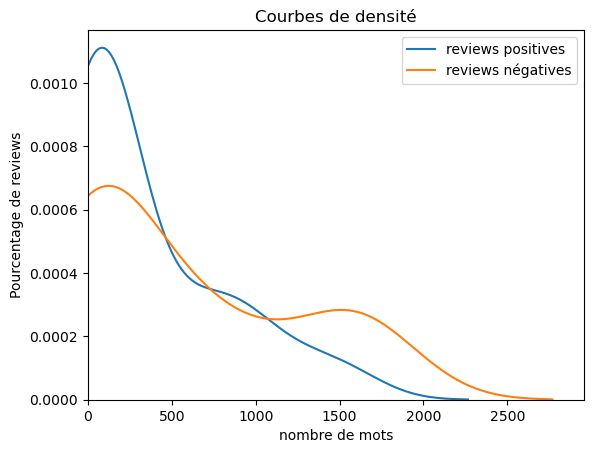

In [25]:
sns.kdeplot(longueur_positif, label="reviews positives")
sns.kdeplot(longueur_negatif, label="reviews négatives")

plt.title("Courbes de densité")
plt.xlabel("nombre de mots")
plt.ylabel("Pourcentage de reviews")
plt.legend()
plt.xlim(0, None)
plt.show()

# Mesure et courbes de densité de lexique :

Un argument pourrait être fait que la longueur des commentaires est moins importante que leur variété lexicale. Les deux sont souvent liées (il y a plus de chance d'avoir de la variété dans un long texte), mais pas toujours : un commentaire qui répète le même mots ("nul nul nul nul nul...nul") n'est pas similaire à un commentaire du même nombre de mot avec une plus grande variété lexicale.

Nous pouvons donc refaire les mesures des courbes de densité afin de comparer les catégories non plus en terme de longueur, mais en terme de variété lexicale.


## Mesure de variété de lexique :

On pourrait vérifier de façon globale si le lexique des commentaires positifs est plus varié par token que le lexique des commentaires négatifs par token.
Dans les faits, il s'agit pour chaque catégorie de calculer son TTR (Token Type Ratio) en divisant le nombre de total de lemmes différents de la catégorie et en le divisant par son nombre total de mots. Une fois ces scores sur 1 récupérés, on divise le score le plus bas par le score le plus haut, optenant ainsi un score de comparaison des variétés de vocabulaire pour les deux classes. Plus cette valeur est proche de 1, plus les textes sont équivalents en terme de variété lexicale.

In [39]:
voc_pos = []
voc_neg = []

for review in corpus["reviews"]["reviews"]:
    if review["score"] == 1:
        voc_pos.append(len(list(set(review["review_body"].split(" ")))))
    else:
        voc_neg.append(len(list(set(review["review_body"].split(" ")))))

tot_voc_pos = sum(voc_pos)
tot_voc_neg = sum(voc_neg)

rel_voc_pos = tot_voc_pos / tot_lg_pos
rel_voc_neg = tot_voc_neg / tot_lg_neg

comparaison_variete = min(rel_voc_pos, rel_voc_neg) / max(rel_voc_pos, rel_voc_neg)
if rel_voc_pos > rel_voc_neg:
    print(
        "la variété relative des commentaires positifs est supérieure à la variété relative des commentaires négatifs"
    )
else:
    print(
        "la variété relative des commentaires négatifs est supérieure à la variété relative des commentaires positifs"
    )
print(f"la mesure de comparaison relative est de {comparaison_rel}.")

la variété relative des commentaires positifs est supérieure à la variété relative des commentaires négatifs
la mesure de comparaison relative est de 0.914669133978322.


## Courbe de densité : variété lexicale

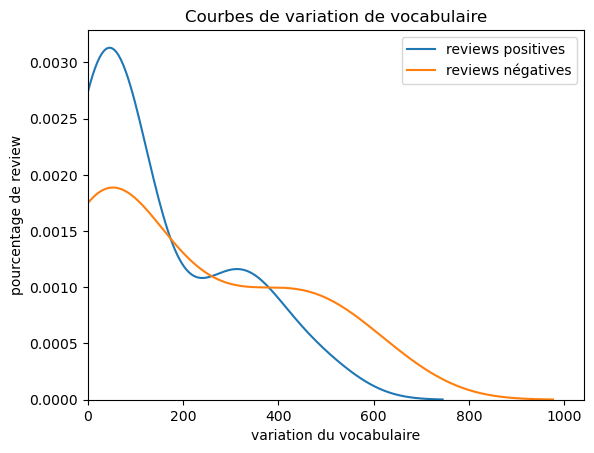

In [40]:
sns.kdeplot(sorted(voc_pos), label="reviews positives")
sns.kdeplot(sorted(voc_neg), label="reviews négatives")
plt.title("Courbes de variation de vocabulaire")
plt.xlabel("variation du vocabulaire")
plt.ylabel("pourcentage de review")
plt.legend()
plt.xlim(left=0)
plt.show()

# Ajustement de la courbe : zoom sur les valeurs pour les textes de 0 à 200 mots :

On peut aller jeter un oeil de plus près aux valeurs pour les textes de 2 à 200 mots, où semblent se concentrer une partie des données. Le déséquilibre de répartition semble un peu moins flagrant, même si on confirme que le plus grand pic de valeurs positives a lieu pour les reviews courtes, alors que la variété de lexique est un tout petit mieux répartie pour les reviews négatives.

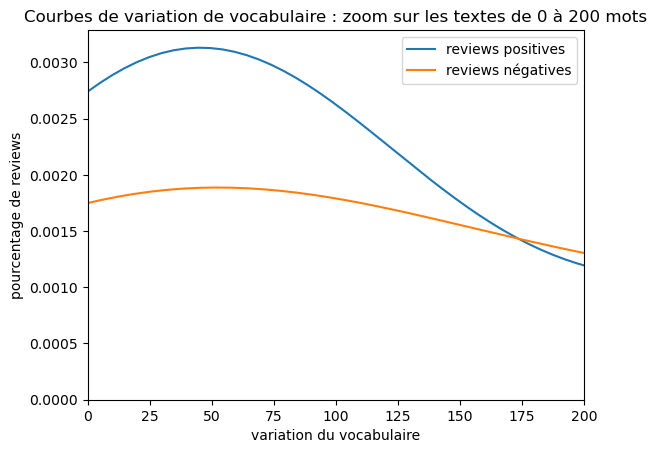

In [38]:
sns.kdeplot(sorted(voc_pos), label="reviews positives")
sns.kdeplot(sorted(voc_neg), label="reviews négatives")
plt.title("Courbes de variation de vocabulaire : zoom sur les textes de 0 à 200 mots")
plt.xlabel("variation du vocabulaire")
plt.ylabel("pourcentage de reviews")
plt.legend()
plt.xlim(left=0, right=200)
plt.show()